In [1]:
import pickle
import re

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import nltk
# nltk.download('all')

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# DATA_PATH = "/content/gdrive/MyDrive/SNLI/"
DATA_PATH = "../data/SNLI/"
TRAIN_DATA_PATH = DATA_PATH +'train.csv'
DEV_DATA_PATH = DATA_PATH +'dev.csv'
TEST_DATA_PATH = DATA_PATH +'test.csv'
MAX_LEN = 50
BINARY_VOCAB_PATH = DATA_PATH +'vocab_binary1mill.pkl'
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001

## Preprocessing Functions

In [7]:
def clean_word(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-zA-Z ]', '', sentence)
    return sentence


def read_data(filepath):
    df = pd.read_csv(filepath)
    similarity_map = {
        'neutral': np.nan,
        'contradiction': 0,
        'entailment': 1,
        '-': np.nan
    }
    df['similarity'] = df['similarity'].apply(
        lambda column: similarity_map[column])
    df.dropna(axis=0, inplace=True)
    df['sentence1'] = df['sentence1'].apply(clean_word)
    df['sentence2'] = df['sentence2'].apply(clean_word)
    return df


def tokenize(sentences):
    tokens = []
    for sentence in sentences:
        tokens.append(word_tokenize(sentence))
    return tokens


def stem_word(sentences):
    tokens = []
    stemmer = PorterStemmer()
    for sentence in sentences:
        sentence_tokens = []
        for word in sentence:
            sentence_tokens.append(stemmer.stem(word))
        tokens.append(sentence_tokens)

    return tokens


def remove_stopwords(sentences):
    tokens = []
    stop = stopwords.words('english')
    for sentence in sentences:
        new_sen = []
        for word in sentence:
            if word not in stop:
                new_sen.append(word)
        tokens.append(new_sen)
    return tokens


def flatten(item_list):
    return [item for sublist in item_list for item in sublist]


def create_vocabulary(sentence1, sentence2):
    sentence1 = set(flatten(sentence1))
    sentence2 = set(flatten(sentence2))
    vocab = sentence1.union(sentence2)
    return sorted(list(vocab))


def create_mappings(vocab):
    word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
    idx2word = {idx + 2: word for idx, word in enumerate(vocab)}
    return word2idx, idx2word


def map_to_token(map_dict, tokens):
    all_tokens = []
    for sentence in tokens:
        sentence_tokens = []
        for word in sentence:
            if word in map_dict.keys():
                sentence_tokens.append(map_dict[word])
            else:
                sentence_tokens.append(1)
        all_tokens.append(sentence_tokens)
    return all_tokens


def prepare_data(
        sentence1,
        sentence2,
        vocab_path,
        training=True,
        return_vocab=False):
    tokens1 = tokenize(sentence1)
    tokens2 = tokenize(sentence2)

    stemed_tokens1 = stem_word(tokens1)
    stemed_tokens2 = stem_word(tokens2)

    if training:
        vocab = create_vocabulary(
            stemed_tokens1, stemed_tokens2)
        pickle.dump(vocab, open(vocab_path, 'wb'))

    else:
        vocab = pickle.load(open(vocab_path, 'rb'))

    word2idx, idx2word = create_mappings(vocab)

    idx_tokens1 = map_to_token(word2idx, stemed_tokens1)
    idx_tokens2 = map_to_token(word2idx, stemed_tokens2)

    padded_tokens1 = pad_sequences(idx_tokens1, maxlen=MAX_LEN)
    padded_tokens1 = pad_sequences(idx_tokens2, maxlen=MAX_LEN)

    data1 = np.array(padded_tokens1, dtype='object').astype('int32')
    data2 = np.array(padded_tokens1, dtype='object').astype('int32')
    if return_vocab:
        return vocab, data1, data2
    return data1, data2
    # return stemed_tokens1, stemed_tokens2


def return_vocab(vocab_path):
    vocab = pickle.load(open(vocab_path, 'rb'))
    return vocab

## 1. Word Count model

In [8]:
df_train = read_data(TRAIN_DATA_PATH)
df_dev = read_data(DEV_DATA_PATH)
df_test = read_data(TEST_DATA_PATH)

In [9]:
train_df = df_train.copy()
test_df = df_test.copy()

In [10]:
def count_words(column):
    return len(column)

In [ ]:
train_df['char_counts_1'] = train_df['sentence1'].apply(count_words)
train_df['char_counts_2'] = train_df['sentence2'].apply(count_words)

test_df['char_counts_1'] = test_df['sentence1'].apply(count_words)
test_df['char_counts_2'] = test_df['sentence2'].apply(count_words)

In [ ]:
train_df.head()

,similarity,sentence1,sentence2,char_counts_1,char_counts_2
1,0.0,a person on a horse jumps over a broken down a...,a person is at a diner ordering an omelette,53,43
2,1.0,a person on a horse jumps over a broken down a...,a person is outdoors on a horse,53,31
4,1.0,children smiling and waving at camera,there are children present,37,26
5,0.0,children smiling and waving at camera,the kids are frowning,37,21
6,0.0,a boy is jumping on skateboard in the middle o...,the boy skates down the sidewalk,60,32


In [ ]:
train_df['char_count_diff'] = abs(train_df['char_counts_1'] - train_df['char_counts_2'])
test_df['char_count_diff'] = abs(test_df['char_counts_1'] - test_df['char_counts_2'])

In [ ]:
def char_count_hypothesis(column):
    if int(column) >= 8:
        return 0
    return 1

In [ ]:
train_df['char_count_predicted'] = train_df['char_count_diff'].apply(char_count_hypothesis)
test_df['char_count_predicted'] = test_df['char_count_diff'].apply(char_count_hypothesis)

In [ ]:
accuracy_train = sum(train_df['similarity'] == train_df['char_count_predicted']) / len(train_df)
accuracy_test = sum(test_df['similarity'] == test_df['char_count_predicted']) / len(test_df)

In [ ]:
accuracy_train

0.47781908843177423

In [ ]:
accuracy_test

0.4752460257380772

### category counts

In [ ]:
print(len(df_train.loc[(df_train['similarity'] == 1)]))
print(len(df_dev.loc[(df_dev['similarity'] == 1)]))
print(len(df_test.loc[(df_test['similarity'] == 1)]))

183414
3329
3368


In [ ]:
print(len(df_train.loc[(df_train['similarity'] == 0)]))
print(len(df_dev.loc[(df_dev['similarity'] == 0)]))
print(len(df_test.loc[(df_test['similarity'] == 0)]))

183185
3278
3237


In [35]:
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow import keras


def binary_base_model(vocab):
    base_model = models.Sequential()
    base_model.add(layers.Embedding(input_dim=len(vocab) + 2, output_dim=128))
    base_model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
    base_model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
    base_model.add(layers.GlobalAveragePooling1D())
    base_model.add(layers.Dense(128, activation='relu'))
    base_model.add(layers.Dropout(0.3))
    base_model.add(layers.Dense(128, activation='relu'))
    return base_model
    # base_model = models.Sequential()
    # base_model.add(layers.Embedding(input_dim=len(vocab) + 2, output_dim=128))
    # base_model.add(layers.Conv1D(128, 3, padding='same'))
    # base_model.add(layers.MaxPool1D())
    # base_model.add(layers.BatchNormalization())
    # base_model.add(layers.Dropout(0.2))
    # base_model.add(layers.Conv1D(128, 3))
    # base_model.add(layers.MaxPool1D())
    # base_model.add(layers.Dropout(0.3))
    # base_model.add(layers.Dense(128, activation='relu'))
    # base_model.add(layers.Dropout(0.2))
    # base_model.add(layers.Dense(128, activation='relu'))
    # base_model.add(layers.Flatten())
    return base_model


def binary_model(vocab, data):
    input1 = keras.Input(shape=(data.shape[1],))
    input2 = keras.Input(shape=(data.shape[1],))

    base_model = binary_base_model(vocab)

    encoding1 = base_model(input1)
    encoding2 = base_model(input2)

    distance = layers.Concatenate()([encoding1, encoding2])
    dense1 = layers.Dense(128, activation='relu')(distance)
    bn = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(128, activation='relu')(bn)
    final = layers.Dense(1, activation='sigmoid')(dense2)
    model = models.Model(inputs=[input1, input2], outputs=final)
    return model

from tensorflow.keras import backend as K


def calculate_mean(x, axis=1):
    return K.mean(x, axis=axis)


def normalize(x):
    return x / K.sqrt(K.sum(x * x, axis=-1, keepdims=True))



def triplet_base_model(vocab):
    base_model = tf.keras.Sequential()
    base_model.add(tf.keras.layers.Embedding(
        input_dim=len(vocab) + 2, output_dim=128))
    base_model.add(tf.keras.layers.GRU(128, return_sequences=True))
    base_model.add(tf.keras.layers.Lambda(calculate_mean, name='mean'))
    base_model.add(tf.keras.layers.Lambda(normalize, name='normalize'))
    return base_model


def triplet_model(vocab, data):
    input1 = tf.keras.layers.Input(shape=(data.shape[1],))
    input2 = tf.keras.layers.Input(shape=(data.shape[1],))

    base_model = triplet_base_model(vocab)

    encoding1 = base_model(input1)
    encoding2 = base_model(input2)

    merged = tf.keras.layers.Concatenate()([encoding1, encoding2])

    model = tf.keras.Model(inputs=[input1, input2], outputs=merged)
    return model


In [ ]:
def TripletLoss(margin=0.25):
    def triplet(y_true, y_pred):
        batch_size = tf.cast(tf.shape(y_true)[0], dtype=tf.float32)
        v1, v2 = y_pred[:, :128], y_pred[:, -128:]
        scores = K.dot(v1, K.transpose(v2))
        positive = tf.linalg.diag_part(scores)
        negative_without_positive = scores - 2 * tf.eye(batch_size)

        closest_negative = tf.reduce_max(negative_without_positive, axis=1)

        negative_zero_on_duplicate = scores * (1.0 - tf.eye(batch_size))

        mean_negative = K.sum(negative_zero_on_duplicate,
                              axis=1) / (batch_size - 1)

        triplet_loss1 = K.maximum(0.0, margin - positive + closest_negative)

        triplet_loss2 = K.maximum(0.0, margin - positive + mean_negative)

        triplet_loss = K.mean(triplet_loss1 + triplet_loss2)

        return triplet_loss
    return triplet

In [7]:
df_train = read_data(TRAIN_DATA_PATH)
df_dev = read_data(DEV_DATA_PATH)
df_test = read_data(TEST_DATA_PATH)

# print(len(df_train.loc[(df_train['similarity'] == 1)]))
# print(len(df_dev.loc[(df_dev['similarity'] == 1)]))
# print(len(df_test.loc[(df_dev['similarity'] == 1)]))
# df_train.drop_duplicates(inplace=True)
# df_dev.drop_duplicates(inplace=True)

In [8]:
df_train

,similarity,sentence1,sentence2
1,0.0,a person on a horse jumps over a broken down a...,a person is at a diner ordering an omelette
2,1.0,a person on a horse jumps over a broken down a...,a person is outdoors on a horse
4,1.0,children smiling and waving at camera,there are children present
5,0.0,children smiling and waving at camera,the kids are frowning
6,0.0,a boy is jumping on skateboard in the middle o...,the boy skates down the sidewalk
...,...,...,...
550144,1.0,a dog with a blue collar plays ball outside,a dog is outside
550146,1.0,four dirty and barefooted children,four children have dirty feet
550147,0.0,four dirty and barefooted children,four kids won awards for cleanest feet
550150,0.0,a man is surfing in a bodysuit in beautiful bl...,a man in a business suit is heading to a board...


In [9]:
df_dev

,similarity,sentence1,sentence2
1,1.0,two women are embracing while holding to go pa...,two woman are holding packages
2,0.0,two women are embracing while holding to go pa...,the men are fighting outside a deli
3,1.0,two young children in blue jerseys one with th...,two kids in numbered jerseys wash their hands
5,0.0,two young children in blue jerseys one with th...,two kids in jackets walk to school
6,0.0,a man selling donuts to a customer during a wo...,a woman drinks her coffee in a small cafe
...,...,...,...
9993,1.0,a uniformed competitor in motocross has crosse...,a person is on a motorcyle with spectators
9994,1.0,a small girl wearing a pink jacket is riding o...,the carousel is moving
9996,0.0,a small girl wearing a pink jacket is riding o...,the girl is moving at the speed of light
9997,1.0,a young girl with blue and pink ribbons in her...,people in a water fountain


In [10]:
df_test

,similarity,sentence1,sentence2
1,1.0,this church choir sings to the masses as they ...,the church is filled with song
2,0.0,this church choir sings to the masses as they ...,a choir singing at a baseball game
4,1.0,a woman with a green headscarf blue shirt and ...,the woman is very happy
5,0.0,a woman with a green headscarf blue shirt and ...,the woman has been shot
6,1.0,an old man with a package poses in front of an...,a man poses in front of an ad
...,...,...,...
9992,0.0,a female dancer wearing all white dancing whil...,some players are playing cricket in ground
9995,0.0,two women are observing something together,two women are standing with their eyes closed
9996,1.0,two women are observing something together,two girls are looking at something
9997,0.0,a man in a black leather jacket and a book in ...,a man is flying a kite


In [11]:
train_sen1 = df_train['sentence1'].tolist()[:100000]
train_sen2 = df_train['sentence2'].tolist()[:100000]

# train_sen1 = df_train['sentence1'].tolist()
# train_sen2 = df_train['sentence2'].tolist()

dev_sen1 = df_dev['sentence1'].tolist()
dev_sen2 = df_dev['sentence2'].tolist()

test_sen1 = df_test['sentence1'].tolist()
test_sen2 = df_test['sentence2'].tolist()

train_label = df_train['similarity'].tolist()
dev_label = df_dev['similarity'].tolist()
test_label = df_test['similarity'].tolist()

In [ ]:
# train_sen1

In [12]:
train_data1, train_data2 = prepare_data(
    sentence1=train_sen1, 
    sentence2=train_sen2,
    vocab_path= BINARY_VOCAB_PATH, 
    training=True,
    )

In [13]:
dev_data1, dev_data2 = prepare_data(
    sentence1=dev_sen1, 
    sentence2=dev_sen2,
    vocab_path= BINARY_VOCAB_PATH, 
    training=False,
    )

In [14]:
test_data1, test_data2 = prepare_data(
    sentence1=test_sen1, 
    sentence2=test_sen2,
    vocab_path= BINARY_VOCAB_PATH, 
    training=False,
    )

In [15]:
train_label = train_label[:100000]

In [16]:
train_label = np.array(train_label).astype('int32')
dev_label = np.array(dev_label).astype('int32')
test_label = np.array(test_label).astype('int32')

In [17]:
vocab = pickle.load(open(BINARY_VOCAB_PATH, 'rb'))

In [36]:
model = binary_model(vocab, train_data1)
# model = triplet_model(vocab, train_data1)

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          2162432     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 256)          0           ['sequential_1[0][0]',     

In [38]:
def compile_and_train(
        model, optimizer,
        loss, metrics: list,
        training_data: tuple,
        evaluation_data: tuple
):
    if metrics:
        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )
    else:
        model.compile(
            optimizer=optimizer,
            loss=loss
        )
    history = model.fit(
        training_data[0], training_data[1],
        batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=evaluation_data)
    return history.history

In [39]:
history = compile_and_train(
    model,
    tf.keras.optimizers.Adam(LEARNING_RATE),
    'binary_crossentropy',
    ['accuracy'],
    ([train_data1, train_data2], train_label),
    ([dev_data1, dev_data2], dev_label)
)

Epoch 1/5
1563/1563 [==============================] - 177s 104ms/step - loss: 0.5348 - accuracy: 0.7222 - val_loss: 0.5027 - val_accuracy: 0.7530
Epoch 2/5
1563/1563 [==============================] - 157s 101ms/step - loss: 0.4741 - accuracy: 0.7688 - val_loss: 0.5009 - val_accuracy: 0.7592
Epoch 3/5
1563/1563 [==============================] - 157s 101ms/step - loss: 0.4493 - accuracy: 0.7831 - val_loss: 0.5122 - val_accuracy: 0.7432
Epoch 4/5
1563/1563 [==============================] - 157s 101ms/step - loss: 0.4285 - accuracy: 0.7956 - val_loss: 0.4922 - val_accuracy: 0.7652
Epoch 5/5
1563/1563 [==============================] - 157s 100ms/step - loss: 0.4093 - accuracy: 0.8065 - val_loss: 0.4906 - val_accuracy: 0.7724


In [40]:
model.save(DATA_PATH + 'binary_loss_model_LSTMMM.h5')

In [41]:
# model = models.load_model(DATA_PATH+'binary_loss_model1.h5')

In [42]:
# def predict(model, sentence1, sentence2, cosine=False):
#     sentence1 = sentence1.reshape(1,50)
#     sentence2 = sentence2.reshape(1,50)
#     v = model.predict([sentence1, sentence2])
#     v1, v2 = v[:,:128], v[:,-128:]
#     similarity = np.dot(v1,v2.T)[0][0]
#     if similarity >= 0.70:
#         return 1
#     return 0

In [43]:
# preds = []
# for idx in range(len(test_data1)):
#     preds.append(predict(model,test_data1[idx], test_data2[idx]))

In [44]:
# preds == 1

In [45]:
# sum(test_label == preds) / len(test_label) #5282

In [46]:
def predict(model,data):
    test_data1, test_data2 = data
    preds = model.predict([test_data1,test_data2])
    preds_list = [1 if p[0] >= 0.5 else 0 for p in preds ]
    return preds_list

In [47]:
preds = predict(model, [test_data1, test_data2])

In [48]:
sum(test_label == preds) / len(test_label)

0.7635124905374716

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
print(classification_report(test_label, preds))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      3237
           1       0.76      0.78      0.77      3368

    accuracy                           0.76      6605
   macro avg       0.76      0.76      0.76      6605
weighted avg       0.76      0.76      0.76      6605



In [49]:
conf_mat = confusion_matrix(test_label, preds)

In [50]:
def draw_confusion_matrix(y_test, y_pred, labels):
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.4)
    df_cm = pd.DataFrame(conf_mat, index = labels,columns =labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(df_cm, annot=True, cmap=plt.get_cmap('OrRd'), fmt='g')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [51]:
def draw_precision_recall_chart(y_test, y_pred, labels):
    clf_report = classification_report(
        y_test,
        y_pred,
        labels=labels,
        target_names=labels,
        output_dict=True
        )
    clf_report_df = pd.DataFrame(clf_report)
    clf_report_df.drop("support", axis=0, inplace=True)
    clf_report_df.drop(['macro avg', "weighted avg"], axis=1, inplace=True)
    sns.set(font_scale=1.4)
    plt.figure(figsize=(10, 8))
    sns.heatmap(clf_report_df.T, annot=True, cmap=plt.get_cmap('OrRd'), fmt='.3g')
    plt.title("Classification Report")
    plt.show()

In [52]:
labels = ['Similar', 'Different']

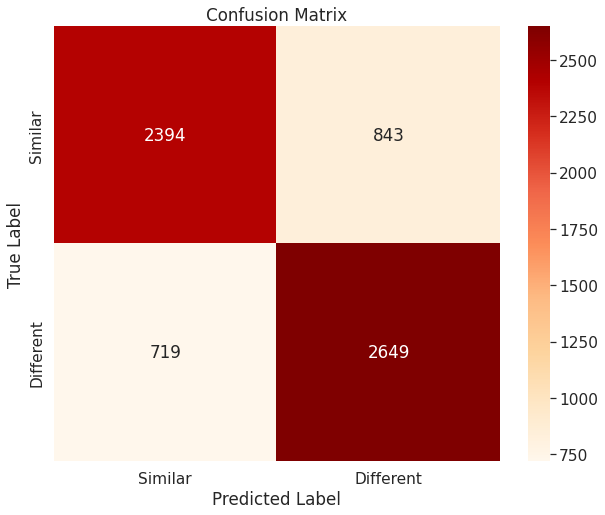

In [53]:
draw_confusion_matrix(test_label, preds, labels)

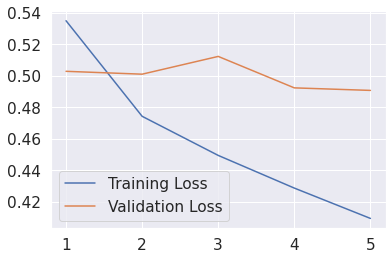

In [54]:
plt.plot(range(1,6), history['loss'], label="Training Loss")
plt.plot(range(1,6), history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

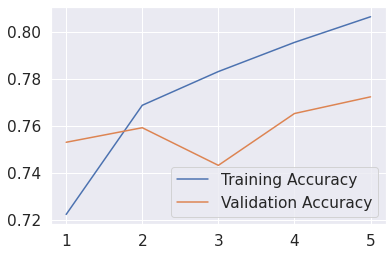

In [55]:
plt.plot(range(1,6), history['accuracy'], label="Training Accuracy")
plt.plot(range(1,6), history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

## Word embedding model

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def sentence_embedding(sentence, model):
    wv = []
    for word in sentence:
        try:
            wv.append(model.wv[word])
        except KeyError:
            pass

    return sum(wv) / len(sentence)
    # return sum([model.wv[word] for word in sentence]) / len(sentence)

def predict(similarity, threshold=0.5):
    if similarity >= threshold:
        return 1
    return 0

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [ ]:
sentences = train_data1 + train_data2

In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec
import os
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [ ]:
model = Word2Vec(sentences=sentences,size=150, window=10, min_count=2, workers=os.cpu_count())
model.train(sentences, total_examples=len(sentences), epochs=20, compute_loss=True, callbacks=[callback()])

Loss after epoch 0: 3932695.0
Loss after epoch 1: 3547935.5
Loss after epoch 2: 3273197.5
Loss after epoch 3: 3134878.0
Loss after epoch 4: 3084898.0
Loss after epoch 5: 2581008.0
Loss after epoch 6: 2561308.0
Loss after epoch 7: 2542918.0
Loss after epoch 8: 2525846.0
Loss after epoch 9: 2507462.0
Loss after epoch 10: 2474754.0
Loss after epoch 11: 2142304.0
Loss after epoch 12: 1672004.0
Loss after epoch 13: 1631464.0
Loss after epoch 14: 1581548.0
Loss after epoch 15: 1540264.0
Loss after epoch 16: 1490976.0
Loss after epoch 17: 1445056.0
Loss after epoch 18: 1368560.0
Loss after epoch 19: 1327440.0


(88914561, 145333040)

In [ ]:
model.save(DATA_PATH+ "word2vec.model")

In [ ]:
sent_1_embeddings = [sentence_embedding(sentence, model) for sentence in train_sen1]
sent_2_embeddings = [sentence_embedding(sentence, model) for sentence in train_sen2]

In [ ]:
def similarity(sentence1, sentence2):
    sentence1 = sentence1.reshape(1,-1)
    sentence2 = sentence2.reshape(1,-1)
    similarity_mat = cosine_similarity(sentence1, sentence2)
    return similarity_mat[0][0]

In [ ]:
similars = [similarity(sent_1_embeddings[idx], sent_2_embeddings[idx]) \
            for idx in range(len(sent_2_embeddings))]

In [ ]:
pred = [predict(similarity_score) for similarity_score in similars]

In [ ]:
accuracy = sum(np.array(train_label) == np.array(pred)) / len(pred)

In [ ]:
accuracy